### Multivariate DCC-GARCH Model notation

$a_t = H_t^{1/2} z_t$ 

$\{z_t\}$ : n × 1 vector of iid errors such that $\mathbb{E}[z_t] = 0$ and $\mathbb{E}[z_tz^T_t] = I$

$H_t$ : conditional variance matrix

$H_t = D_tR_tD_t$

$D_t = diag(h_{i,t}, \cdots, h_{n,t})$

$h_{i,t} = \alpha_{i,0} + \alpha_{i,1}a^2_{t-1} + \beta_{i,1}h_{i,t-1}$

$R_t = Q^{*-1}\overline{Q}Q^{*-1}$

$Q_t = (1-a-b)\overline Q + a\epsilon_{t-1}\epsilon_{t-1}^T + bQ_{t-1}$

$\epsilon_t \sim \mathcal{N}(0,R_t)$

### paper notation

$\Sigma_{t+\Delta t} = (ACC^*+CC^* A^*)\Delta t +e^{-A\Delta t}\Sigma_te^{-A^*\Delta t}+B(\overline{Z}-Z_t)(\overline{Z}-Z_t)^*B^*\Delta t$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [111]:
# param dict
parameters = {}

# 10 assets
num_assets = 10
num_rows_per_asset = 5

# calculated in R
a = 0.007073296
b = 0.658588119

# import from R
coef = pd.read_csv('coef.csv')

# mu, ar1, omega, alpha, beta 0,1,2,3,4 for each asset - 5 values for each asset so 500 total values
parameters['alpha'] = np.array([coef.loc[i,'x'] for i in range(3,(num_assets*num_rows_per_asset),5)])
parameters['beta'] = np.array([coef.loc[i,'x'] for i in range(4,(num_assets*num_rows_per_asset),5)])
parameters['omega'] = np.array([coef.loc[i,'x'] for i in range(2,(num_assets*num_rows_per_asset),5)])
parameters['Q_bar'] = pd.read_csv('Q_bar.csv').drop('Unnamed: 0',axis=1).to_numpy()
parameters['H_init'] = pd.read_csv('H_init.csv').drop('Unnamed: 0',axis=1).to_numpy()
parameters['Q'] = pd.read_csv('Q_init.csv').drop('Unnamed: 0',axis=1).to_numpy()
parameters['T'] = 1000
parameters['small_scalar'] = 1e-5
parameters['num_assets'] = 10



In [160]:
# this will be returned
generated_data = {}

condNum_list = []
a_list = []
H_list = []

# initialize
a0 = np.linalg.cholesky(parameters['H_init'])@np.random.multivariate_normal(np.zeros(parameters['num_assets']),1*np.identity(parameters['num_assets']))

# needed to ensure H psd
h0 = np.ones(parameters['num_assets'])*parameters['small_scalar']

Q = parameters['Q']

T = 1000

for t in range(T):
    # compute R_t
    ### UPDATE: first compute decomp then do inversion 
    Q_star_inv = np.linalg.inv(np.diag(Q.diagonal()))

    R = Q_star_inv@parameters['Q_bar']@Q_star_inv

    # compute D_t
    h1 = parameters['omega'] + parameters['alpha']*a0**2 + parameters['beta']*h0
    D = np.power(np.diag(h1),1/2)

    # compute H
    H = D@R@D

    # draw z
    z = np.random.multivariate_normal(np.zeros(num_assets),1*np.identity(num_assets))

    # compute a: a = 𝐻^1/2 @ z
    a1 = np.linalg.cholesky(H)@z

    # draw e
    e = np.random.multivariate_normal(np.zeros(num_assets),R)

    # step Q
    Q = (1-a-b)*parameters['Q_bar'] + a*a0@a0.T + b*Q

    # step a,h
    h0 = h1
    a0 = a1.squeeze()

    # correlation matrices - keep track of our generated data
    condNum_list.append(np.linalg.cond(R))
    # returns
    a_list.append(e)

# [assets,num_days]
returns_close = np.cumsum(np.vstack(a_list),axis=1).T + 100

# roll 1 day forward to get open,close - close becomes new open
returns_open = np.roll(returns_close,1,axis=1)

# start at 0 
returns_open[:,0] = np.zeros(num_assets)

observation = np.stack([returns_open,returns_close],axis=2)
# observation = np.concatenate((returns_stack,np.tile(np.asarray(condNum_list),(num_assets,1))[:,:,None]),axis=2)
condNum_array = np.asarray(condNum_list)

In [161]:
observation = np.divide(observation[:,:,1:2], observation[:,:,0:1], out=np.zeros_like(observation[:,:,0:1]),\
          where=observation[:,:,0:1]!=0)

In [162]:
observation[0,:,0]

array([0.        , 0.99168424, 1.01062298, 0.98242861, 1.00529082,
       1.01973729, 0.97440323, 0.9940057 , 1.0141546 , 0.99583512,
       0.98691953, 1.0290652 , 0.98360991, 0.99278712, 1.01123862,
       1.01815951, 0.98266913, 0.99060067, 0.99424954, 1.02091306,
       1.00072791, 1.00285978, 0.99093616, 0.99342104, 0.9996716 ,
       1.01473985, 0.99967183, 1.00396877, 0.98637885, 1.01831204,
       0.99100563, 0.99015598, 1.01141615, 1.00576982, 0.97236125,
       1.03014574, 0.98668375, 0.98287053, 1.00505633, 1.01699461,
       1.00332891, 0.99763944, 0.98454294, 1.00880779, 0.98336349,
       1.02829034, 0.98922615, 0.99478937, 1.02950007, 0.98600405,
       0.9891371 , 0.99961864, 0.99565816, 1.02298596, 0.97803631,
       1.01833969, 0.98943082, 1.00691766, 0.99806192, 0.9915741 ,
       1.00847039, 0.99001738, 0.98907997, 1.00233278, 1.02036514,
       1.00752864, 0.98753889, 1.02865369, 0.96272942, 0.99277838,
       1.01238154, 0.992161  , 1.00349988, 1.00732822, 0.98524

In [152]:
returns_close = returns_close + 100

In [ ]:
# can't divide - need a new way

In [88]:
a = 1
l = []
for i in range(len(returns_close[0,:])):
    l.append(a)
    a = a*(1+returns_close[0,i])

In [89]:
# start with price = 100? to make it 

In [90]:
a = np.cumsum(np.asarray(a_list),axis=1)

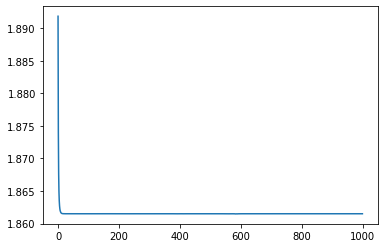

In [163]:
# condition number plot
plt.plot(condNum_array)

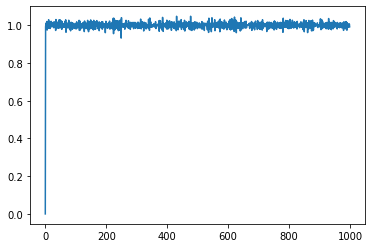

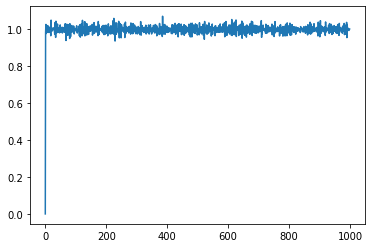

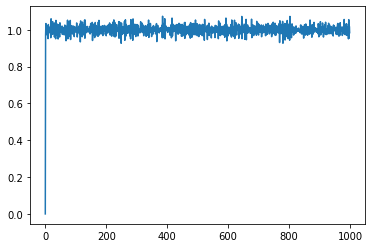

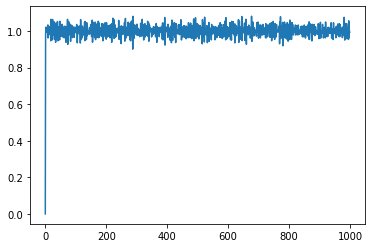

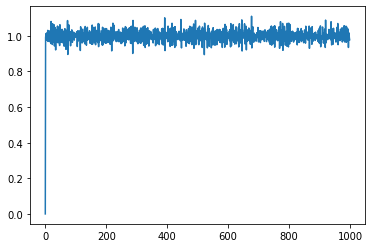

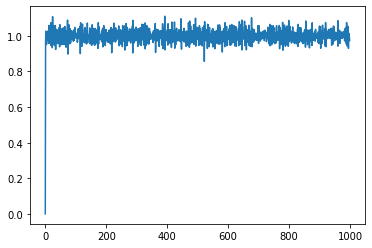

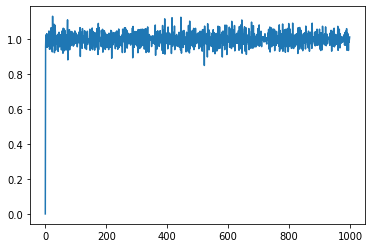

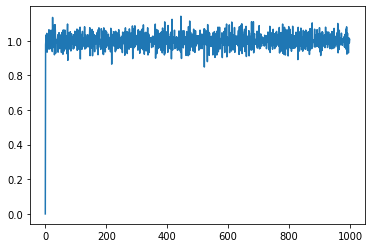

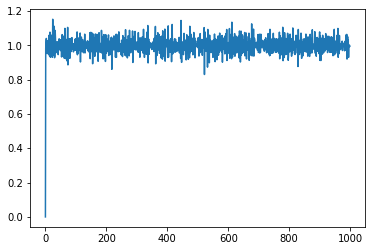

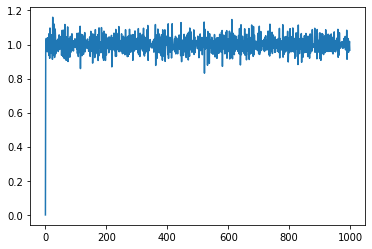

In [164]:
# returns plot
if True:
    for j in range(10):
        plt.figure(j)
        plt.plot([observation[j][i] for i in range(1000)])

In [270]:
returns = np.vstack(generated_data['return_vecs'])
cond_nums = generated_data['condition_nums']

In [274]:
np.cumsum(returns,axis=1)

(1000, 10)

In [241]:
class DataGenerator(object):
    """Acts as data provider for each new episode."""
    
    step = 0
    
    # def __init__(self, history, abbreviation, steps=730, window_length=50, start_idx=0, start_date=None):
    def __init__(self, parameters, steps=730, window_length=50, start_idx=0):
        """
        New Args:
            parameters: dictionary of mgarch parameters from R
            steps: the total number of steps to simulate, default is 2 years
            window_length: observation window, must be less than 50

        Old Args:
            history: (num_stocks, timestamp, 5) open, high, low, close, volume
            abbreviation: a list of length num_stocks with assets name
            steps: the total number of steps to simulate, default is 2 years
            window_length: observation window, must be less than 50
            start_date: the date to start. Default is None and random pick one.
                        It should be a string e.g. '2012-08-13'
        """
        # assert history.shape[0] == len(abbreviation), 'Number of stock is not consistent'
        import copy

        self.parameters = parameters
        self.steps = steps + 1
        self.window_length = window_length
        self.idx = 0
        # self.start_idx = start_idx
        # self.start_date = start_date

        # make immutable class
        # self._data = history.copy()  # all data
        # self.asset_names = copy.copy(abbreviation)

        # NEW
        self._data = self.generate_data()
        
        print('Data generated')
        # get data for this episode, each episode might be different. you can change start date for each episode
        # if self.start_date is None:
        #     self.idx = np.random.randint(low=self.window_length, high=self._data.shape[1] - self.steps)
        # else:
        #     # compute index corresponding to start_date for repeatable sequence
        #     self.idx = date_to_index(self.start_date) - self.start_idx
        #     assert self.idx >= self.window_length and self.idx <= self._data.shape[1] - self.steps, \
        #         'Invalid start date, must be window_length day after start date and simulation steps day before end date'
        # print('Start date: {}'.format(index_to_date(self.idx)))

    def _step(self):
        # get observation matrix from history, exclude volume, maybe volume is useful as it
        # indicates how market total investment changes. Normalize could be critical here
        self.step += 1
        
        # OLD
        # data in shape [num_assets, num_days, 3]
        # last dim = [open, close, condition_num]
        obs = self._data[:, self.step:self.step + self.window_length, :].copy()
        
        # normalize obs with open price
        
        # OLD
        # used for compute optimal action and sanity check
        ground_truth_obs = self._data[:, self.step + self.window_length:self.step + self.window_length + 1, :].copy()
        
        done = self.step >= self.steps
        return obs, done, ground_truth_obs

    def reset(self):
        self.step = 0
        
        # get data for this episode, each episode might be different.
        # OLD
        '''
        if self.start_date is None:
            self.idx = np.random.randint(
                low=self.window_length, high=self._data.shape[1] - self.steps)
        else:
            # compute index corresponding to start_date for repeatable sequence
            self.idx = date_to_index(self.start_date) - self.start_idx
            assert self.idx >= self.window_length and self.idx <= self._data.shape[1] - self.steps, \
                'Invalid start date, must be window_length day after start date and simulation steps day before end date'
        # print('Start date: {}'.format(index_to_date(self.idx)))
        '''
        
        data = self._data[:, self.idx - self.window_length:self.idx + self.steps + 1, :]
        # apply augmentation?
        self.data = data
        return self.data[:, self.step:self.step + self.window_length, :].copy(), \
               self.data[:, self.step + self.window_length:self.step + self.window_length + 1, :].copy()
        
       
    def generate_data(self):

        T = self.steps
        Q_bar = self.parameters['Q_bar']
        Q = self.parameters['Q']
        num_assets = self.parameters['num_assets']
        small_scalar = self.parameters['small_scalar']

        condNum_list = []
        a_list = []

        # initialize
        a0 = np.linalg.cholesky(parameters['H_init'])@np.random.multivariate_normal(np.zeros(parameters['num_assets']),1*np.identity(parameters['num_assets']))

        # needed to ensure H psd
        h0 = np.ones(parameters['num_assets'])*parameters['small_scalar']

        Q = parameters['Q']

        for t in range(T):
            # compute R_t
            Q_star_inv = np.linalg.inv(np.diag(Q.diagonal()))

            R = Q_star_inv@parameters['Q_bar']@Q_star_inv

            # compute D_t
            h1 = parameters['omega'] + parameters['alpha']*a0**2 + parameters['beta']*h0
            D = np.power(np.diag(h1),1/2)

            # compute H
            H = D@R@D

            # draw z
            z = np.random.multivariate_normal(np.zeros(num_assets),1*np.identity(num_assets))

            # compute a: a = 𝐻^1/2 @ z
            a1 = np.linalg.cholesky(H)@z

            # draw e
            e = np.random.multivariate_normal(np.zeros(num_assets),R)

            # step Q
            Q = (1-a-b)*parameters['Q_bar'] + a*np.outer(e,e) + b*Q

            # step a,h
            h0 = h1
            a0 = a1.squeeze()

            # covariance matrices - keep track of our generated data
            condNum_list.append(np.linalg.cond(H))
            H_list.append(H)
            # returns
            a_list.append(a0)
        
        # [assets,num_days]
        returns_close = np.vstack(a_list).T
        
        # roll 1 day forward to get open,close - close becomes new open
        returns_open = np.roll(returns_close,1,axis=1)
        # start at 0 
        returns_open[:,0] = np.zeros(num_assets)
        
        returns_stack = np.stack([returns_open,returns_close],axis=2)
        
        return np.concatenate((returns_stack,np.tile(np.asarray(condNum_list),(num_assets,1))[:,:,None]),axis=2)




In [242]:
src = DataGenerator(parameters)

Data generated


In [247]:
src._data[:,0,:]

array([[ 0.00000000e+00,  5.13443346e-04,  3.56787376e+01],
       [ 0.00000000e+00, -1.35379608e-02,  3.56787376e+01],
       [ 0.00000000e+00, -1.00041007e-02,  3.56787376e+01],
       [ 0.00000000e+00, -7.69607979e-03,  3.56787376e+01],
       [ 0.00000000e+00, -7.17834395e-04,  3.56787376e+01],
       [ 0.00000000e+00, -1.15705884e-02,  3.56787376e+01],
       [ 0.00000000e+00,  3.54751405e-03,  3.56787376e+01],
       [ 0.00000000e+00, -3.29198383e-02,  3.56787376e+01],
       [ 0.00000000e+00,  1.25939393e-02,  3.56787376e+01],
       [ 0.00000000e+00, -1.19536173e-03,  3.56787376e+01]])

In [67]:
obs, done, ground_truth_obs = src._step()


In [68]:
done

False

In [73]:
len(src.reset())

2

In [171]:
x = src._data[:,:10].copy()
x = x.reshape((10,731))

# x[:,0] = np.zeros(10)

In [200]:
x = src._data[:3,:10].copy()
xt = x.T
xt_roll = np.roll(xt,1,axis=1)

In [202]:
xt

array([[-0.00396196, -0.00676917,  0.00394428],
       [ 0.01494571,  0.00625784, -0.00614409],
       [ 0.01100305, -0.0116527 , -0.02147639],
       [ 0.01113241,  0.01448249,  0.00287   ],
       [-0.00573877, -0.00112289,  0.00250141],
       [-0.00971665,  0.00707416,  0.01502355],
       [-0.00024103,  0.00598471, -0.00348159],
       [-0.02447628,  0.01107117,  0.01235571],
       [-0.00527164, -0.01244061, -0.00237634],
       [ 0.00452465, -0.00256529,  0.00326928]])

In [204]:
xt_roll[:,0] = np.zeros(10)

In [209]:
xt.shape

(10, 3)

In [210]:
x_stack = np.stack([xt_roll,xt],axis=2)

In [225]:
cond = np.arange(3)
cond = np.tile(cond,(10,1))

In [230]:
tensor = np.concatenate((x_stack,cond[:,:,None]),axis=2)

In [234]:
tensor[:,1,:]

array([[-3.96195575e-03, -6.76916963e-03,  1.00000000e+00],
       [ 1.49457098e-02,  6.25783617e-03,  1.00000000e+00],
       [ 1.10030484e-02, -1.16526963e-02,  1.00000000e+00],
       [ 1.11324130e-02,  1.44824940e-02,  1.00000000e+00],
       [-5.73877457e-03, -1.12289098e-03,  1.00000000e+00],
       [-9.71664974e-03,  7.07415753e-03,  1.00000000e+00],
       [-2.41031340e-04,  5.98470529e-03,  1.00000000e+00],
       [-2.44762836e-02,  1.10711674e-02,  1.00000000e+00],
       [-5.27163790e-03, -1.24406098e-02,  1.00000000e+00],
       [ 4.52464702e-03, -2.56528537e-03,  1.00000000e+00]])

In [170]:
x_roll[:,0]

array([-0.00114444,  0.0055232 , -0.02506296, -0.00421315,  0.00564157,
       -0.00749296, -0.00424176, -0.00942122, -0.0154212 , -0.01311892])